# Investigate Titanic dataset

Daniel Suruagy

May, 21 2017

In this project, I will explore some facts about demographics data from Titanic passengers. This dataset contains information like Name, Age, Sex, Boarding class and, most important of all, the survival information. From this data, is it possible to extract correlations that could be applied to identify the survivors profile?

For what I've read and knew about the Titanic tragedy, I thought these questions could be answered:

- How greater is the percentage of survivors from first class compared with the percentage for second and third class survivors? It is knew that the lifeboats were on the top of the ship, near first class acomodations. So I've expected the first class passengers were the majority of survivors.

- Between survivors, what is the proportion between female in relation to male passengers?

- What is the relation between sex and age groups, if the rescue priority was for women and children?

- Is there any correlation between cabin allocation and surviving?


To answer my questions, I've implemented code to plot data, helping to visualize what I've expected to see. So I've started importing the data file obtained on Udacity Project Details page:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

# Importing Titanic passengers data to a Pandas DataFrame:
titanic_df = pd.read_csv('titanic-data.csv')

Populating the interactive namespace from numpy and matplotlib


I've defined some functions to improve some formatting not present on the raw data, like grouping passengers ages and get the deck corresponding to cabins:

In [2]:
# Grouping ages based on names, for use in a plotting below
def group_age(age):
    if age > 0 and age <= 2: #Infants (0 - 2)
        return 'Infant'
    elif age > 2 and age <= 12: #Children (0 – 12)
        return 'Child'
    elif age > 12 and age <= 17: #Adolescents (13 – 17)
        return 'Adolescent'
    elif age > 17 and age < 65: #Adults (18+)
        return 'Adult'
    elif age >= 65:
        return 'Older Adult'
    else:
        return 'Unknown'

# To obtain the deck it is necessary to take the first character.
def get_cabin_deck(cabin):
    if not pd.isnull(cabin): # if parameter is not null (NaN or None)
        return cabin[0]      # return first char of Cabin Id, i.e. the Deck code.
    
# Applying these functions to the Dataframe, creating two new columns: Age group and Cabin deck
titanic_df['Age group'] = titanic_df['Age'].apply(group_age)
titanic_df['Cabin Deck'] = titanic_df['Cabin'].apply(get_cabin_deck)

# Changing class numbers to strings
titanic_df.replace(to_replace={'Pclass':{1: 'First', 2: 'Second', 3: 'Third'}}, inplace=True)

# Obtaining a DataFrame for survivors data only
titanic_df.replace(to_replace={'Survived':{0: 'No', 1: 'Yes'}}, inplace=True)
survived_df = titanic_df[titanic_df['Survived'] == 'Yes'] 


The first question I'd like to answer is about how greater is the percentage of first class survivors in this dataset. So I thought it will be nice if I could see it in pie plots, showing the total distribution of passengers and comparing to the number of survivors per class. To do that, I've counted how many survivors exists grouped by Ticket class number.

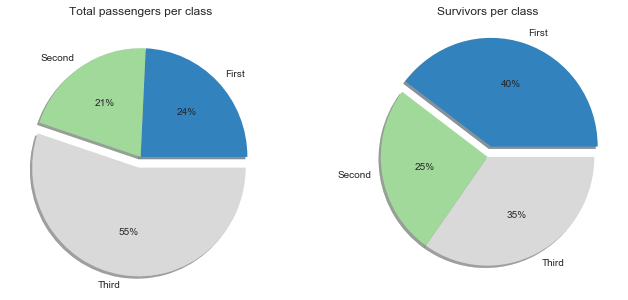

In [11]:
# Grouping sample by Ticket class (Pclass) and counting how many there are in each class:
total_ticket_class = titanic_df.groupby(['Pclass'])['Name'].count()

# Grouping survivers data by Ticket class (Pclass), then counting how many are in the groups
survived_ticket_class = survived_df.groupby(['Pclass'])['Survived'].count()

# Plotting in pies, with percent shown inside
fig, axarr = plt.subplots(ncols=2)

total_ticket_class.plot.pie(autopct='%2.f%%', colormap='tab20c', explode=[0, 0, 0.1],
                           title='Total passengers per class', shadow=True, ax=axarr[0])

survived_ticket_class.plot.pie(autopct='%2.f%%', figsize=(11, 5), colormap='tab20c', explode=[0.1, 0, 0],
                           title='Survivors per class', shadow=True, ax=axarr[1])
for ax in axarr:
    axarr[0].set_ylabel('')
axarr[1].set_ylabel('')

plt.subplots_adjust(wspace=0.3)

Considering the total number of passengers, the majority is from the third class. This proportion is not reflected if we compare with survivors number, where the majority is from first class. In this dataset, which is a subset of real data, third-class survivors percentage is very close to the first class percentage but lower. Sadly, it is known that first class passengers had priority to occupy lifeboats, a fact that can be viewed in this data visualization.

Next, I would like to compare the relationship between sex and age groups for the survivors.

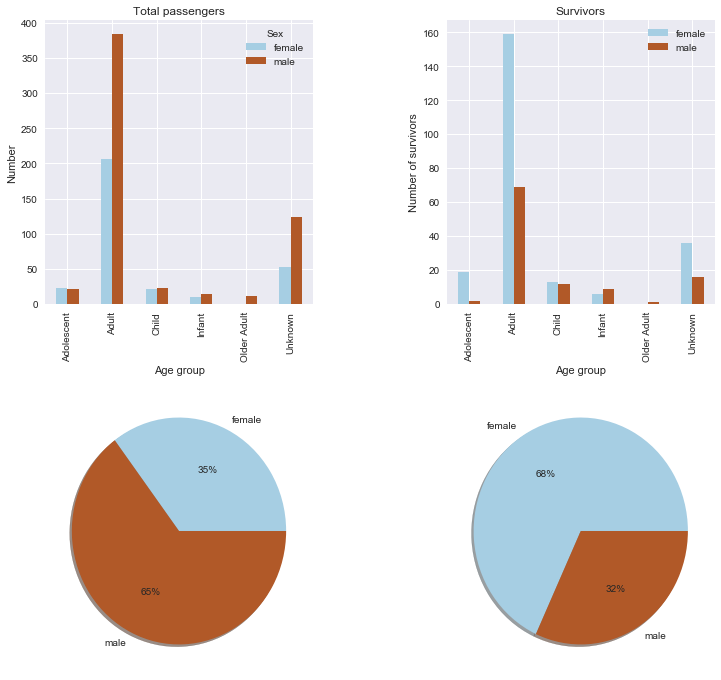

In [48]:
# Grouping survivors by sex and age group, then counting how many are in the groups
survived_by_sex_and_age = survived_df.groupby(['Sex','Age group'], as_index=False)['Survived'].count()
survived_by_sex = survived_df.groupby(['Sex'])['PassengerId'].count()

# Obtaining a dataframe with female survivors data
survived_female = pd.DataFrame(survived_by_sex_and_age[survived_by_sex_and_age['Sex'] == 'female'])
survived_female.rename(columns={"Survived":"female"}, inplace=True)

# Obtaining a dataframe with male survivors data
survived_male = pd.DataFrame(survived_by_sex_and_age[survived_by_sex_and_age['Sex'] == 'male'])
survived_male.rename(columns={"Survived":"male"}, inplace=True)

# Merging these two dataframes based on age groups, obtaining a DataFrame where these age group are the indexes and
# male and female totals were shown in separate columns.
survived_by_age_group = survived_female.merge(survived_male, on='Age group', how='outer')
survived_by_age_group.set_index('Age group', inplace=True)
del survived_by_age_group['Sex_x']
del survived_by_age_group['Sex_y']

# Sorting indexes, because there are indexes that does not exist in female data and causes indexes out of order
survived_by_age_group.sort_index(inplace=True)



# Grouping the total number of men and women by age group
total_sex_age = titanic_df.groupby(['Sex','Age group'], as_index=False).count()
total_sex = titanic_df.groupby(['Sex'])['PassengerId'].count()

# Reshaping total data, in a more compact way than done in the previous survived data
pivoted_total_sex_age = total_sex_age.pivot(index='Age group', columns='Sex', values='PassengerId')


# Plotting data, in a grid, where the first column shows total passengers information,
# and survivors only on the second column.
fig, axarr = plt.subplots(2, 2, figsize=(12,12))
plt.subplots_adjust(wspace=0.3)
pivoted_total_sex_age.plot(kind='bar', colormap='Paired', title='Total passengers', ax=axarr[0, 0])
survived_by_age_group.plot(kind='bar', colormap='Paired', title='Survivors', ax=axarr[0, 1])
axarr[0, 0].set_ylabel('Number')
axarr[0, 1].set_ylabel('Number of survivors')

total_sex.plot.pie(autopct='%2.f%%', colormap='Paired', shadow=True, ax=axarr[1, 0])
survived_by_sex.plot.pie(autopct='%2.f%%', colormap='Paired', shadow=True, ax=axarr[1, 1])

for ax in axarr[1]:
    ax.set_ylabel('')

plt.subplots_adjust(wspace=0.5, hspace=0.3)

The first column of this plot is about total passengers data. From the bar and pie charts, we can see that the majority of passengers was formed by adult men. Adolescent and childhood age groups had almost the same number of passengers.

From the survivors' charts in the second column, it is clear that the rescue priority was to save women and children. The sex proportion was inverse, turning the majority to the female sex. Except for the Infant and Older Adult groups, the female survivors' number is bigger. 

Indeed, the total number of male passengers who survived is much smaller than female survivors. I've treated the unavailable information of age like Unknown, and again I could see that female numbers are bigger.

To finish, I need to know if there is any correlation between cabin decks and survival numbers. The higher the deck, corresponding to first class cabins, nearer their ocupants are from lifeboat.

In [ ]:
# Grouping data by cabin deck and surviving information, then couting how many people are in each group:
deck_counting_df = titanic_df.groupby(['Cabin Deck', 'Survived'], as_index=False).count()
# Reshaping data for show surviving counting in each row, indexed by the cabin deck
pivoted_deck_data = deck_counting_df.pivot(index='Cabin Deck', columns='Survived', values='Name')

# Plotting the result
pivoted_deck_data.plot(kind='bar', colormap='Set1', 
                       title='Is there any correlation between cabin allocation and surviving?')

I think this information is not conclusive, mainly because there is not so many information about cabins on passengers data. 

The group 0 correspond to not survivors and 1 to survivors. 

Anyway, it can be seen that the higher deck levels have more survivors, because deck A were on top and deck G on the bottom of the ship.

To conclude, I could see that the big majority of survivors were women of the first class of the ship.